In [12]:
from scrape_search import scrape_search_hotel_urls

urls = await scrape_search_hotel_urls("Goa", max_pages=5)

2024-08-18 17:01:14.607 | INFO     | search_responses:scrape_location_data:25 - scraping location data: Goa
2024-08-18 17:01:15.040 | INFO     | search_responses:scrape_location_data:99 - found 10 results
2024-08-18 17:01:15.041 | SUCCESS  | scrape_search:scrape_search_hotel_urls:64 - found hotel search url: https://www.tripadvisor.com/Hotels-g297604-Goa-Hotels.html
2024-08-18 17:01:16.384 | INFO     | scrape_search:parse_search_page:22 - parsing search page: https://www.tripadvisor.com/Hotels-g297604-Goa-Hotels.html
2024-08-18 17:01:16.433 | DEBUG    | scrape_search:scrape_search_hotel_urls:90 - Goa: only scraping 5 max pages from 243 total
2024-08-18 17:01:16.435 | INFO     | scrape_search:scrape_search_hotel_urls:96 - Goa: found total_results=7261, page_size=30. Scraping 5 pagination pages
2024-08-18 17:01:17.504 | INFO     | scrape_search:parse_search_page:22 - parsing search page: https://www.tripadvisor.com/Hotels-g297604-oa90-Goa-Hotels.html
2024-08-18 17:01:17.566 | INFO     | 

In [13]:
from scrape_search import save_to_csv
import pandas as pd

save_to_csv(urls, "Goa.csv")

2024-08-18 17:01:17.779 | SUCCESS  | scrape_search:save_to_csv:128 - Data saved to datasets\Goa.csv


In [14]:
hotels = pd.read_csv("./datasets/Goa.csv")
hotels.head()

,url,name
0,https://www.tripadvisor.com/Hotel_Review-g3069...,Zone Connect by The Park Calangute Goa
1,https://www.tripadvisor.com/Hotel_Review-g3069...,Summit Calangute Resort And Spa
2,https://www.tripadvisor.com/Hotel_Review-g3038...,Goa Marriott Resort & Spa
3,https://www.tripadvisor.com/Hotel_Review-g3069...,The LaLiT Golf & Spa Resort Goa
4,https://www.tripadvisor.com/Hotel_Review-g7759...,"Holiday Inn Resort Goa, An IHG Hotel"


In [15]:
from scrape_reviews import scrape_hotel_reviews, save_to_csv

url = "https://www.tripadvisor.in/Hotel_Review-g303891-d1656706-Reviews-Capital_O_39676_Country_Spa_Wellness_Resort-Kovalam_Kanchipuram_District_Tamil_Nadu.html" 
hotel_data = await scrape_hotel_reviews(url, max_review_pages=10)

filename = save_to_csv(hotel_data, url)

# hotel_data = await scrape_hotel_reviews(hotels['url'][0], max_review_pages=10)

# filename = save_to_csv(hotel_data, hotels['url'][0])

2024-08-18 17:01:20.941 | INFO     | scrape_reviews:scrape_hotel_reviews:97 - scraped 100 reviews from https://www.tripadvisor.in/Hotel_Review-g303891-d1656706-Reviews-Capital_O_39676_Country_Spa_Wellness_Resort-Kovalam_Kanchipuram_District_Tamil_Nadu.html
2024-08-18 17:01:21.056 | SUCCESS  | scrape_reviews:save_to_csv:126 - Saved 100 reviews to Capital_O_39676_Country_Spa_Wellness_Resort_reviews.csv


In [16]:
reviews_df = pd.read_csv("./datasets/" + filename)
print(reviews_df.shape)
reviews_df.head()

(100, 4)


,Title,Text,Rating,Trip Date
0,"Excellent Location, Nice Property but Poor Mai...",This is my visit to Kovalam. I stayed in this ...,3,July 2013
1,Relaxing stay and Spa,We decided to choose this resort because of me...,4,October 2014
2,BED EXPIRIENCE,"hotel staff is not so good,average hotel,hotel...",2,October 2014
3,Pathetic,My worst experience during the last two days o...,1,April 2012
4,terrible,When we reached there we were happy to see the...,1,February 2012


**1. Supervised Sentiment Analysis (Multiclass Classification)**

In [17]:
# Creating labels for the reviews using the ratings
# Ratings: 1, 2 - Negative, 3 - Neutral, 4, 5 - Positive
# Sentiment: 0 - Negative, 1 - Neutral, 2 - Positive

def categorize_rating(rating):
    if rating in [1, 2]:
        return 0
    elif rating == 3:
        return 1
    else:
        return 2

reviews_df['Sentiment'] = reviews_df['Rating'].apply(categorize_rating)

print(reviews_df[['Rating', 'Sentiment']].head())
reviews_df["Rating"].value_counts()


   Rating  Sentiment
0       3          1
1       4          2
2       2          0
3       1          0
4       1          0


4    25
1    23
3    21
2    20
5    11
Name: Rating, dtype: int64

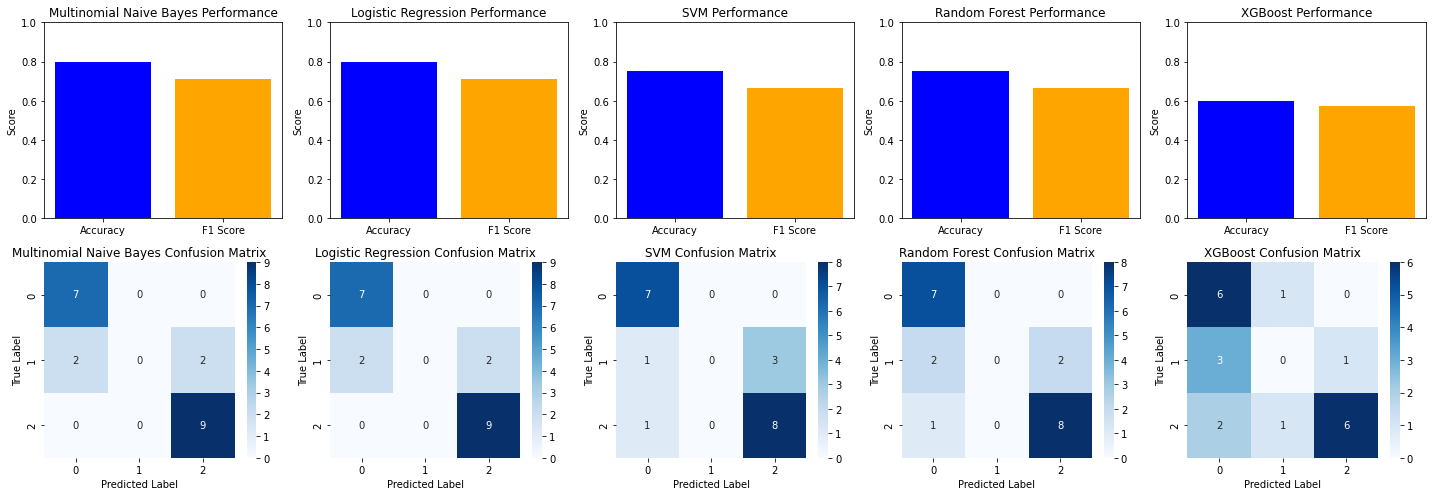

                         Accuracy  F1 Score
Multinomial Naive Bayes      0.80  0.711250
Logistic Regression          0.80  0.711250
SVM                          0.75  0.666250
Random Forest                0.75  0.667183
XGBoost                      0.60  0.570833


In [22]:
from sklearn.feature_extraction.text import ENGLISH_STOP_WORDS
import re
from nltk.stem import PorterStemmer
from nltk.tokenize import word_tokenize
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, f1_score
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix
import warnings
warnings.filterwarnings("ignore")

# Step 1: Combine title and text & Preprocess the text data
reviews_df['Combined'] = reviews_df['Title'] + ' ' + reviews_df['Text']

stemmer = PorterStemmer()

def preprocess_text(text):
    text = text.lower()
    
    text = re.sub(r'http\S+|www\S+|https\S+', '', text, flags=re.MULTILINE)
    
    text = re.sub(r'[^\w\s]', '', text)
    
    text = re.sub(r'\s+', ' ', text).strip()
    
    tokens = word_tokenize(text)
    tokens = [stemmer.stem(word) for word in tokens if word not in ENGLISH_STOP_WORDS]
    
    return ' '.join(tokens)

reviews_df['Combined'] = reviews_df['Combined'].apply(preprocess_text)

# Step 2: Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(reviews_df['Combined'], reviews_df['Sentiment'], test_size=0.2, random_state=42)

# Step 3: Convert the text data into numerical form using TF-IDF
vectorizer = TfidfVectorizer(max_features=500)
X_train_tfidf = vectorizer.fit_transform(X_train)
X_test_tfidf = vectorizer.transform(X_test)

# Step 4: Define the models, including MultinomialNB
models = {
    "Multinomial Naive Bayes": MultinomialNB(),
    "Logistic Regression": LogisticRegression(random_state=42, max_iter=1000),
    "SVM": SVC(random_state=42),
    "Random Forest": RandomForestClassifier(random_state=42),
    "XGBoost": XGBClassifier(random_state=42, use_label_encoder=False, eval_metric='mlogloss')
}

# Step 5: Train and evaluate each model
performance_metrics = {}
conf_matrices = {}

for model_name, model in models.items():
    model.fit(X_train_tfidf, y_train)
    
    y_pred = model.predict(X_test_tfidf)
    
    accuracy = accuracy_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred, average='weighted')
    
    performance_metrics[model_name] = {
        "Accuracy": accuracy,
        "F1 Score": f1
    }
    
    conf_matrix = confusion_matrix(y_test, y_pred)
    conf_matrices[model_name] = conf_matrix

# Step 6: Plot the performance metrics and confusion matrices
num_models = len(models)
fig, axes = plt.subplots(nrows=2, ncols=num_models, figsize=(20, 7))

for idx, (model_name, metrics) in enumerate(performance_metrics.items()):
    axes[0, idx].bar(["Accuracy", "F1 Score"], [metrics["Accuracy"], metrics["F1 Score"]], color=['blue', 'orange'])
    axes[0, idx].set_ylim(0, 1)
    axes[0, idx].set_title(f"{model_name} Performance")
    axes[0, idx].set_ylabel("Score")
    
for idx, (model_name, conf_matrix) in enumerate(conf_matrices.items()):
    sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', ax=axes[1, idx])
    axes[1, idx].set_title(f"{model_name} Confusion Matrix")
    axes[1, idx].set_xlabel("Predicted Label")
    axes[1, idx].set_ylabel("True Label")

plt.tight_layout()
plt.show()

performance_df = pd.DataFrame(performance_metrics).T
print(performance_df)

1. **Multinomial Naive Bayes:** Achieves 80% accuracy and a balanced F1 Score of 0.711, indicating strong overall performance in sentiment classification.

2. **Logistic Regression:** Matches Naive Bayes with 80% accuracy and an F1 Score of 0.711, demonstrating effective sentiment analysis with a good balance between Precision and Recall.

3. **SVM (Support Vector Machine):** Shows 75% accuracy and a lower F1 Score of 0.666, suggesting slightly less effective performance in balancing Precision and Recall.

4. **Random Forest:** Delivers 75% accuracy and a slightly better F1 Score of 0.667, indicating comparable performance to SVM with a marginally better balance between Precision and Recall.

5. **XGBoost:** Performs the weakest with 60% accuracy and an F1 Score of 0.570, reflecting lower effectiveness in sentiment classification.

In [23]:
from sklearn.model_selection import cross_val_score, StratifiedKFold
from sklearn.ensemble import BaggingClassifier, AdaBoostClassifier
from sklearn.linear_model import LogisticRegression
import numpy as np

log_reg = LogisticRegression(random_state=42, max_iter=1000, penalty='l2')

# 1. Cross-Validation
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
cv_scores = cross_val_score(log_reg, X_train_tfidf, y_train, cv=cv, scoring='accuracy')

print(f"Cross-Validation Accuracy: {np.mean(cv_scores):.4f} ± {np.std(cv_scores):.4f}")

# 2. Bagging with Logistic Regression
bagging_clf = BaggingClassifier(base_estimator=log_reg, n_estimators=10, random_state=42)
bagging_clf.fit(X_train_tfidf, y_train)
y_pred_bagging = bagging_clf.predict(X_test_tfidf)

print(f"Bagging Accuracy: {accuracy_score(y_test, y_pred_bagging):.4f}")
print(f"Bagging F1 Score: {f1_score(y_test, y_pred_bagging, average='weighted'):.4f}")

# 3. Boosting with Logistic Regression (using AdaBoost)
boosting_clf = AdaBoostClassifier(base_estimator=log_reg, n_estimators=50, random_state=42)
boosting_clf.fit(X_train_tfidf, y_train)
y_pred_boosting = boosting_clf.predict(X_test_tfidf)

print(f"Boosting Accuracy: {accuracy_score(y_test, y_pred_boosting):.4f}")
print(f"Boosting F1 Score: {f1_score(y_test, y_pred_boosting, average='weighted'):.4f}")


Cross-Validation Accuracy: 0.6375 ± 0.0468
Bagging Accuracy: 0.8000
Bagging F1 Score: 0.7113
Boosting Accuracy: 0.6500
Boosting F1 Score: 0.5755


- The normal Logistic Regression model shows strong performance with 80% accuracy and a well-balanced F1 Score of 0.711. 

- Bagging maintains this high accuracy and F1 Score, enhancing model stability. 

- In contrast, Boosting decreases both accuracy (65%) and F1 Score (0.5755), suggesting it may not be as effective for this sentiment analysis task.

In [24]:
from sklearn.decomposition import PCA
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, f1_score

# Apply PCA to the TF-IDF features
pca = PCA(n_components=50)  # Adjust n_components as needed
X_train_pca = pca.fit_transform(X_train_tfidf.toarray())
X_test_pca = pca.transform(X_test_tfidf.toarray())

model = LogisticRegression(max_iter=1000)  # You might need to adjust max_iter based on convergence
model.fit(X_train_pca, y_train)

y_pred = model.predict(X_test_pca)

accuracy = accuracy_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred, average='weighted')

print(f'Accuracy: {accuracy:.4f}')
print(f'F1 Score: {f1:.4f}')


Accuracy: 0.8000
F1 Score: 0.7113


After applying PCA (Principal Component Analysis), the Logistic Regression model maintains strong performance with an accuracy of 80% and an F1 Score of 0.7113, indicating that dimensionality reduction did not negatively impact the model's ability to effectively classify sentiment, but also did not improve the performance.

**2. Lexicon-Based Sentiment Analysis**

In [28]:
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer

# Step 1: Initialize the VADER sentiment analyzer
analyzer = SentimentIntensityAnalyzer()

# Step 2: Apply sentiment analysis to each review
reviews_df['Lexicon Sentiment'] = reviews_df['Combined'].apply(lambda x: analyzer.polarity_scores(x)['compound'])

# Step 3: Categorize the sentiment as positive, neutral, or negative
def categorize_compound(compound):
    if compound >= 0.05:
        return 2
    elif compound <= -0.05:
        return 0
    else:
        return 1

reviews_df['Lexicon Sentiment Category'] = reviews_df['Lexicon Sentiment'].apply(categorize_compound)

print(reviews_df[['Rating', 'Lexicon Sentiment', 'Lexicon Sentiment Category']].head())

# Step 4: Evaluate the performance of the VADER sentiment analysis
accuracy = accuracy_score(reviews_df['Sentiment'], reviews_df['Lexicon Sentiment Category'])
f1 = f1_score(reviews_df['Sentiment'], reviews_df['Lexicon Sentiment Category'], average='weighted')

print(f'\nAccuracy: {accuracy:.4f}')
print(f'F1 Score: {f1:.4f}')

   Rating  Lexicon Sentiment  Lexicon Sentiment Category
0       3             0.8225                           2
1       4             0.9923                           2
2       2             0.4588                           2
3       1            -0.8885                           0
4       1             0.4215                           2

Accuracy: 0.6000
F1 Score: 0.5392


The `SentimentIntensityAnalyzer` from VADER achieves an accuracy of 60% and an F1 Score of 0.5392. This suggests that while it captures sentiment reasonably well, it is less effective than some other models (e.g., Logistic Regression) in balancing Precision and Recall for this sentiment analysis task.